In [1]:
#!code .

# Pricing d'option sur cryptomonnaies
#### LL

### Imports

Les imports se font de la manière suivante
- Le scraper se trouve dans le module Market
- Les modèles sont dans le module Models
- Des fonctions utiles se trouvent dans le sous-module utils du module Models, on y retrouve des fonctions d'évaluations pour les modèles

In [2]:
from Cryptocurrency_pricing.Market import deribit_data as dm
from Cryptocurrency_pricing.Models.utils import *
from Cryptocurrency_pricing.Models import BlackScholes, Merton, Heston

import numpy as np
import plotly.graph_objects as go   

### Scraping

Pour effectuer le scraping de données depuis deribit, il faut instancier la classe Scraper du module deribit_data, l'argument $\verb+currency+$ permet de choisir la cryptomonnaie sur laquelle on veut récupérer les données du marché (BTC, ETH, etc...) 

In [3]:
data = dm.Scraper(currency='BTC')

Une fois le scraper initialisé, on collecte la donnée par la méthode $\verb+collect_data+$.
- $\tt{max\_workers}$ determine le nombre de threads qui vont marcher en parallèle pour scraper la donnée (20 max pour ne pas surcharger les requêtes)
- $\tt{save\_csv = True}$ pour sauvegarder la donnée scrapée en csv.


In [4]:
raw_df = data.collect_data(max_workers = 15, save_csv = False)

Data Collected


In [5]:
raw_df.head(3)

,underlying_price,underlying_index,timestamp,stats,state,settlement_price,open_interest,min_price,max_price,mark_price,...,change_id,bids,bid_iv,best_bid_price,best_bid_amount,best_ask_price,best_ask_amount,asks,ask_iv,option_type
0,32751.42,BTC-24SEP21,1625748933402,"{'volume': 1.2, 'price_change': 0.0, 'low': 0....",open,0.32,545.5,0.245,0.4055,0.313144,...,32830765789,"[[0.3075, 0.6], [0.0005, 0.3]]",86.42,0.3075,0.6,0.656,0.1,"[[0.656, 0.1], [0.7065, 0.1], [2.158, 0.5]]",282.79,P
1,34617.04,BTC-24JUN22,1625748934409,"{'volume': None, 'price_change': None, 'low': ...",open,0.39,0.0,0.316,0.4955,0.393491,...,32830770122,"[[0.3575, 9.0], [0.169, 0.5], [0.0005, 0.1]]",80.49,0.3575,9.0,0.437,9.0,"[[0.437, 9.0]]",105.02,C
2,32567.44,BTC-9JUL21,1625748933402,"{'volume': 0.2, 'price_change': 0.9524, 'low':...",open,0.05,20.7,0.019,0.0925,0.052298,...,32830771573,"[[0.0495, 1.0], [0.0485, 1.3], [0.047, 4.0], [...",77.11,0.0495,1.0,0.055,1.0,"[[0.055, 1.0], [0.056, 0.8], [0.0565, 4.0], [0...",129.42,C


La donnée brute sur les options contient beaucoup d'information, elles seront traitées en amont dans les modèles.

### Initialisation des modèles

Les modèles s'initialisent de la façon suivante, avec deux paramètres, le dataframe brut scrapé, ainsi que le type d'option à garder : $$\tt{ \{C : Call, P : Put, B : Both\} }$$

In [6]:
BS = BlackScholes(raw_df.copy(), 'B')
M = Merton(raw_df.copy(), 'B')
H = Heston(raw_df.copy(), 'B')

Chaque modèle possède désormais un DataFrame $\tt{df}$ trié lors de l'initialisation des modèles par la pipeline de tri du module $\tt{utils}$, il ne contient que les informations utiles pour la suite.

In [7]:
BS.df.tail(25)

,S,K,V,_T,bids,asks,last_price,mark_price,option_type,mid_iv,mark_iv,mid,moneyness
339,32558.45,70000.0,13.5,0.058569,0.000000,0.001732,0.0005,0.000470,C,63.495,116.86,0.000866,0.465121
270,32698.34,20000.0,6.0,0.135281,0.013634,0.017604,0.0150,0.015344,P,106.255,106.45,0.015619,1.634917
152,32646.63,25000.0,37.0,0.135281,0.036266,0.045839,0.0390,0.040028,P,95.840,95.85,0.041052,1.305865
338,32688.05,30000.0,78.6,0.135281,0.084499,0.166046,0.0917,0.089078,P,89.540,89.67,0.125273,1.089602
100,32631.88,35000.0,35.8,0.135281,0.094340,0.103670,0.1000,0.097285,C,85.580,85.78,0.099005,0.932339
219,32674.05,35000.0,23.5,0.135281,0.152621,0.181662,0.1705,0.168963,P,86.140,85.77,0.167142,0.933544
75,32629.45,40000.0,89.7,0.135281,0.050794,0.084427,0.0550,0.053618,C,84.990,84.88,0.067611,0.815736
222,32678.43,45000.0,64.5,0.135281,0.028144,0.036527,0.0325,0.029920,C,85.865,85.57,0.032335,0.726187
252,32694.24,50000.0,38.1,0.135281,0.015848,0.021537,0.0195,0.017713,C,87.840,87.85,0.018692,0.653885
352,32682.69,55000.0,26.0,0.135281,0.009952,0.027159,0.0115,0.011459,C,91.320,91.24,0.018556,0.594231


La méthode $\tt{initialize}$ permet d'initialiser les paramètres propres à chaque modèle, depuis un vecteur $\theta$, le booléen $\tt{reset}$ permet de choisir de réinitialiser aux derniers paramètres calibrés enregistrés.

In [8]:
BS.initialize(reset = True)
M.initialize(reset = True)
H.initialize(reset = True)

### Ajouts des volatiliés implicites

La méthode append_imp_vol_to_df ajoute une colonne au DataFrame du modèle avec les volatilités implicites, calculées  dans le module $\tt{common\_all}$

In [9]:
BS.append_imp_vol_to_df()
M.append_imp_vol_to_df()
H.append_imp_vol_to_df()

In [60]:
BS.append_loc_vol_to_df()
M.append_loc_vol_to_df()
H.append_loc_vol_to_df()

/Users/pierrebelamri/Documents/GitHub/deribit_scraping/Cryptocurrency_pricing/Models/common_all.py:196: RuntimeWarning:

invalid value encountered in double_scalars



### Ajouts des Prix respectifs de chaque modèles aux df 

Chaque modèle possède une méthode $\tt{Price}$ qui calcule le prix d'une option sous ce modèle.

In [10]:
S = 34205.37
K = 35000.0
T = 0.067142
v = 0.028870
Flag = 'C'
print("Black-Scholes Price : ${}".format(S*BS.Price(S=S, K=K, T=T, sigma=v, CallPutFlag=Flag)))
print("Merton Price        : ${}".format(S*M.Price(S=S, K=K, T=T, sigma=v, CallPutFlag=Flag)))
print("Heston Price        : ${}".format(S*H.Price(S=S, K=K, T=T, sigma=v, CallPutFlag=Flag)))
print("Market Price        : ${}".format(S*0.077089))

Black-Scholes Price : $3626.812075362676
Merton Price        : $3629.7543747284208
Heston Price        : $2996.9214525019
Market Price        : $2636.8577679300006


La vectorisation de cette fonction et son application aux lignes du DataFrame permet de calculer une liste de prix qui pourront être comparés avec ceux du marché. Cela ce fait via la méthode $\tt{append\_price}$.

In [11]:
BS.append_price()
M.append_price()
H.append_price()

BS.df[['BS_PRICE','mid']].head()

,BS_PRICE,mid
232,0.000006,0.000952
254,0.000240,0.004061
224,0.000958,0.001192
358,0.001834,0.029851
283,0.003862,0.026545


In [12]:
bad_prices_indexes = H.df[H.df.mid >= 1].index


BS.df = BS.df.drop(bad_prices_indexes)
H.df = H.df.drop(bad_prices_indexes)
M.df = M.df.drop(bad_prices_indexes)

bad_prices_indexes =  BS.df[BS.df.BS_PRICE >= 1].index

BS.df = BS.df.drop(bad_prices_indexes)
H.df = H.df.drop(bad_prices_indexes)
M.df = M.df.drop(bad_prices_indexes)


bad_prices_indexes =  M.df[M.df.MERTON_PRICE >= 1].index

BS.df = BS.df.drop(bad_prices_indexes)
H.df = H.df.drop(bad_prices_indexes)
M.df = M.df.drop(bad_prices_indexes)

bad_prices_indexes =  H.df[H.df.HESTON_PRICE >= 1].index

BS.df = BS.df.drop(bad_prices_indexes)
H.df = H.df.drop(bad_prices_indexes)
M.df = M.df.drop(bad_prices_indexes)




In [13]:
#H.df[H.df.mid >= 0].index

### Optimisation des paramètres (pour Merton et Heston)

In [14]:
H.optimize(x0 = None, tol = 1e-4, max_iter =700, update_when_done=True )

array([0.80612604, 0.43853186, 0.04723601, 0.32496829, 0.17656341])

In [15]:
M.optimize(tol = 1e-4, max_iter=700, update_when_done=True)

array([0.01084344, 0.0010937 , 0.00020984])

In [145]:
from sklearn.metrics import mean_absolute_error

x = BS.df['K']
y = BS.df['_T']
z = BS.df['mark_price']

x1 = BS.df['K']
y1 = BS.df['_T']
z1 = BS.df['BS_PRICE']

x2 = M.df['K']
y2 = M.df['_T']
z2 = M.df['MERTON_PRICE']

x3 = H.df['K']
y3 = H.df['_T']
z3 = H.df['HESTON_PRICE']






fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z , mode='markers', name='Real Market Price', marker=dict(opacity=0.8)),
                      go.Scatter3d(x=x1, y=y1, z=z1, mode='markers', name='BlackScholes Model Price', marker=dict(opacity=0.8)),
                      go.Scatter3d(x=x2, y=y2, z=z2, mode='markers', name='Merton Model Price', marker=dict(opacity=0.8),),
                      go.Scatter3d(x=x3, y=y3, z=z3, mode='markers', name='Heston Model Price', marker=dict(opacity=0.8))])


fig.update_scenes(xaxis_title_text='Strike', yaxis_title_text='Exp', zaxis_title_text='Price') 
fig.show()

#rms_merton = mean_squared_error(z2, z3, squared=False)



In [17]:
Eval_Metrics(BS=BS,M=M,H=H)

=============== Root Mean Squared Error ================

B&S    = 1.789 %
MERTON    = 1.293 %
HESTON    = 1.289 % 

=============== Mean Absolute Error ================

B&S    = 0.841 %
MERTON    = 0.704 %
HESTON    = 0.795 % 

=============== R2 Score ================

B&S    = 61.382 %
MERTON    = 85.955 %
HESTON    = 83.69 % 



In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (10,7)

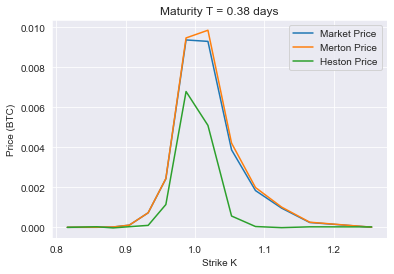

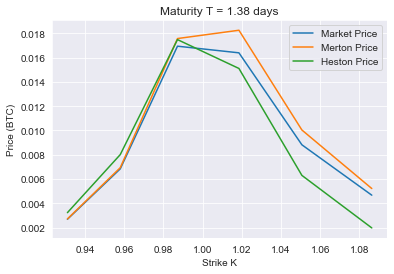

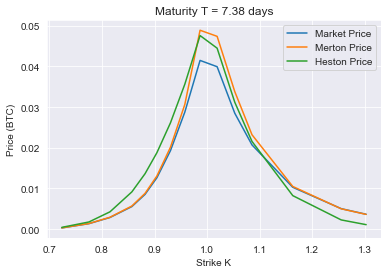

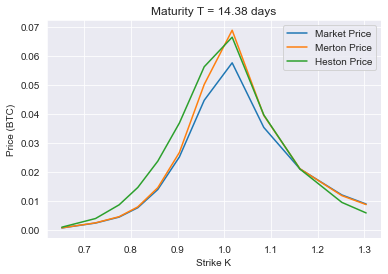

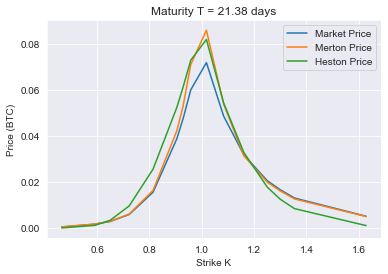

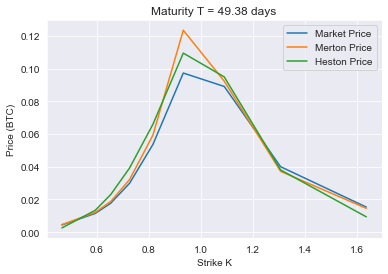

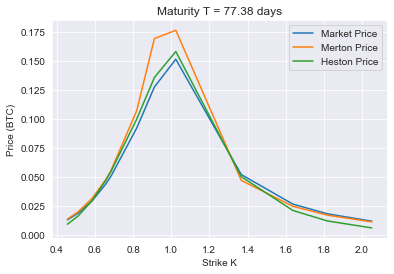

In [24]:


mkt  = pd.DataFrame([BS.df['S'],BS.df['_T'],BS.df['K'],BS.df['mark_price'],BS.df['BS_PRICE'],H.df['HESTON_PRICE'],M.df['MERTON_PRICE']]).T

mkt.dropna(inplace = True)
L_T = []

for T in mkt['_T']:
    
    if T not in L_T:
        
        L_T.append(T)
        extract_mkt = mkt[mkt._T == T]
        
        s = extract_mkt['S']

        plt.plot(s/extract_mkt['K'],extract_mkt['mark_price'],label='Market Price')
        #plt.plot(extract_mkt['K'],extract_mkt['BS_PRICE'], label='Black-Scholes Price')
        plt.plot(s/extract_mkt['K'],extract_mkt['MERTON_PRICE'], label='Merton Price')
        plt.plot(s/extract_mkt['K'],extract_mkt['HESTON_PRICE'],label='Heston Price')
        plt.xlabel('Strike K')
        plt.ylabel('Price (BTC)')
        plt.legend()
        

        plt.title('Maturity T = {} days'.format(round(T*365,2)))
        plt.savefig('T_{}_days.png'.format(round(T*365,2)))
        plt.show()
    

In [141]:
new_df = BS.df.copy()
new_df['K'] = new_df['K']/32000

In [142]:
new_df = new_df[(new_df._T >= 0.003)*(.0<new_df.K)*(new_df.K < 1.6)][['K', '_T', 'L_VOL']]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:204: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead



In [143]:
new_df = new_df.pivot(index = '_T',columns='K', values='L_VOL')
new_df.interpolate(inplace=True)
new_df.head()

K,0.50000,0.56250,0.62500,0.75000,0.78125,0.81250,0.87500,0.93750,0.96875,1.00000,...,1.06250,1.09375,1.12500,1.15625,1.18750,1.25000,1.31250,1.40625,1.50000,1.56250
_T,,,,,,,,,,,,,,,,,,,,,
0.003774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.336906,0.214349,0.088220,...,0.184781,0.283858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.020213,NaN,NaN,NaN,NaN,0.435056,0.382207,0.268638,0.156892,0.103199,0.041709,...,0.088342,0.138602,0.183879,0.222203,0.263962,0.333005,0.396944,0.469585,NaN,NaN
0.039391,NaN,NaN,NaN,NaN,0.326944,0.283378,0.199408,0.115340,0.103199,0.027434,...,0.066214,0.113277,0.138290,0.222203,0.197652,0.251158,0.300865,0.365185,NaN,0.453502
0.058569,NaN,NaN,0.467877,0.310976,0.274438,0.238139,0.166743,0.095896,0.103199,0.024198,...,0.054095,0.087952,0.115444,0.222203,0.197652,0.214558,0.300865,0.313825,NaN,0.396309
0.135281,NaN,NaN,0.327556,0.246382,0.192733,0.238139,0.166743,0.069920,0.103199,0.021029,...,0.054095,0.057993,0.088175,0.222203,0.197652,0.150020,0.300865,0.221178,NaN,0.280628


In [149]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv

z = new_df
x = list(new_df.columns)
y = list(new_df.index)


fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Implied Volatility surface', autosize=False,
width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.update_scenes(xaxis_title_text='Moneyness S/K', yaxis_title_text='Exp', zaxis_title_text='Local Volatility') 
fig.show()
